# Dependencies

In [1]:
#pip install gcastle==1.0.3

In [2]:
#pip install graphviz

In [3]:
#pip install lingam

In [4]:
#pip install causal-learn

In [5]:
#pip install pydot

In [6]:
#pip install pygraphviz

In [7]:
#pip install cdt

In [8]:
#pip install networkx

In [9]:
# pytorch

# Imports


In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression, LassoLarsIC
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import seaborn as sns
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.FCMBased.ANM import ANM
from causallearn.search.PermutationBased import GRaSP
import cdt
from cdt.causality.pairwise import ANM
from cdt.causality.graph import LiNGAM, CAM
from cdt.data import load_dataset

import pandas as pd
import lingam
from lingam.utils import make_dot

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, DirectLiNGAM, GOLEM, ICALiNGAM, GES
import networkx as nx
import torch

from scipy.stats import shapiro, anderson, spearmanr, levene, norm, bartlett
import warnings
warnings.filterwarnings('ignore') ### suppress warnings for default values in algorithms, warnings about future changes etc.


Detecting 1 CUDA device(s).
2023-03-08 18:03:44,337 - C:\Users\Uni\anaconda3\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-03-08 18:03:44,375 - C:\Users\Uni\anaconda3\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [11]:
X = pd.read_csv('a1_data.csv') ### csv data should be in same folder as ipynb

X.head() ### print first 5 rows

,A,B,C,D,E,F,G,H,I,J,K
0,3.179665,3.030625,3.222752,2.836624,3.386284,1.910165,2.179628,3.464657,3.705143,3.921797,3.566766
1,3.313155,3.127535,3.367189,2.799483,2.527001,2.359419,2.461049,3.394200,3.002324,3.487035,3.753581
2,3.531847,3.554489,3.441636,2.582776,2.730851,2.263097,2.461049,3.452962,3.531599,3.773342,3.254741
3,3.621384,3.828081,3.640896,2.704508,1.727649,1.855651,2.021082,3.570291,3.611415,3.725917,3.328318
4,3.285691,3.206716,2.992451,2.562289,3.011359,2.414187,2.612864,3.331957,3.143080,3.679484,3.874796


In [12]:
X.describe() ### basic statistics about data

,A,B,C,D,E,F,G,H,I,J,K
count,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000
mean,3.581855,3.463647,3.452983,3.260402,2.984953,3.075823,3.197797,3.487102,3.351592,3.258339,3.274824
std,0.378379,0.353852,0.395709,0.577910,0.492341,0.532411,0.477088,0.381390,0.434271,0.657896,0.436652
min,1.711091,1.539091,1.236145,1.325193,1.395194,1.092741,1.120213,0.711992,1.294027,0.693624,1.648960
25%,3.374607,3.269612,3.229361,2.840228,2.684764,2.706726,2.891299,3.312105,3.056303,3.110205,3.003621
50%,3.586721,3.452918,3.495931,3.273143,2.980771,3.097046,3.230381,3.488138,3.346475,3.371435,3.293180
75%,3.816371,3.672239,3.703152,3.708043,3.297037,3.438193,3.515241,3.710964,3.678814,3.669142,3.542723
max,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000


## Histogram for every column

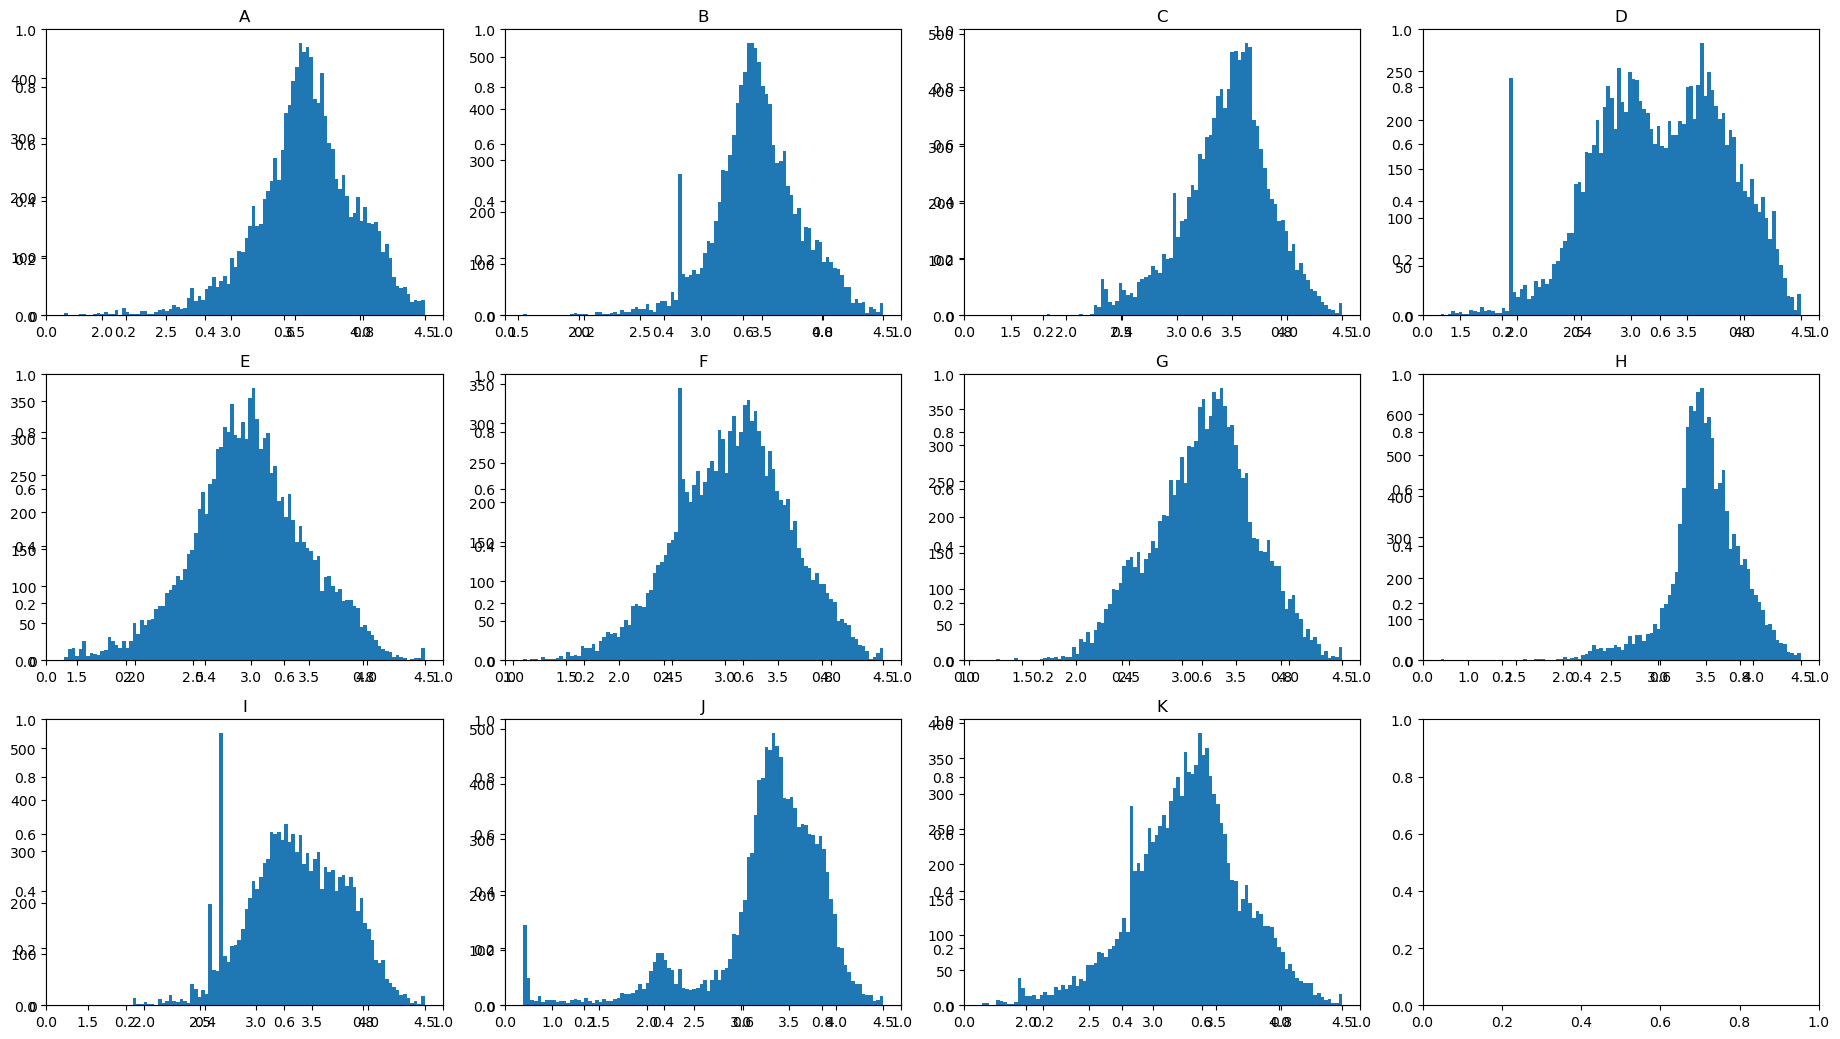

In [13]:
fig, ax = plt.subplots(3,4, tight_layout=True)

Tot = X.shape[1] + 1
Position = range(1,X.shape[1] + 1)
#fig = plt.figure(1)
fig.set_size_inches(18.5, 10.5)

for column, k in zip(X, range(Tot)) :
        
    ax = fig.add_subplot(3,4,Position[k])
    ax.set_title(column)
    ax.hist(X[column], bins=100)
    
    

## Pearson Correlation Between columns as Heatmap

<AxesSubplot:>

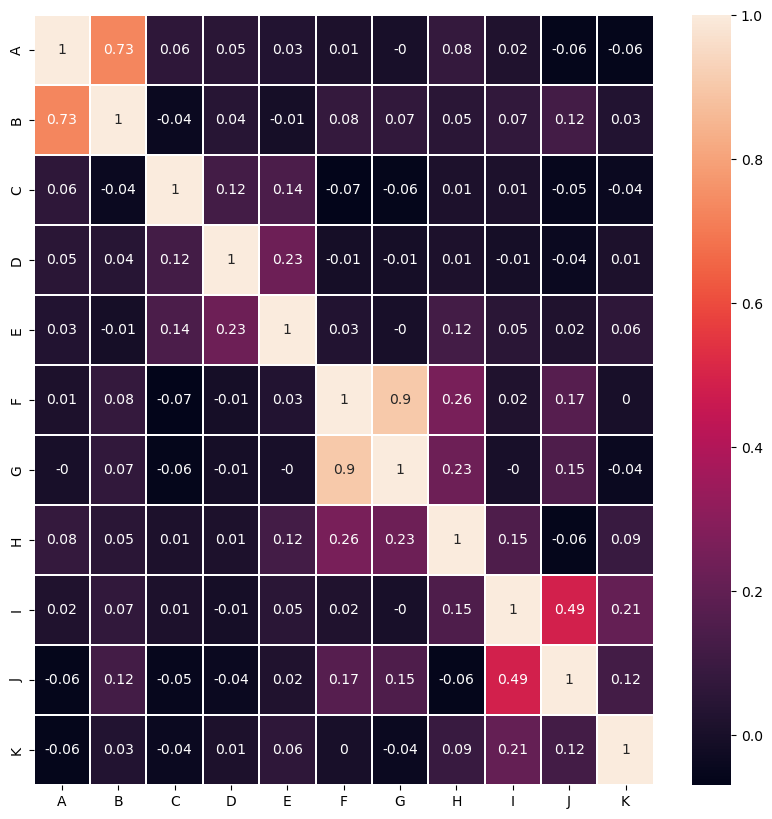

In [14]:
X_corr_round = X.corr(method='pearson').round(decimals=2)
#print(X_corr_round)

fig, ax = plt.subplots(figsize=(10,10))         ### Sample figsize in inches
sns.heatmap(X_corr_round, linewidth=0.3, annot=True)

# Spearman R Correlation between columns as Heatmap



<AxesSubplot:>

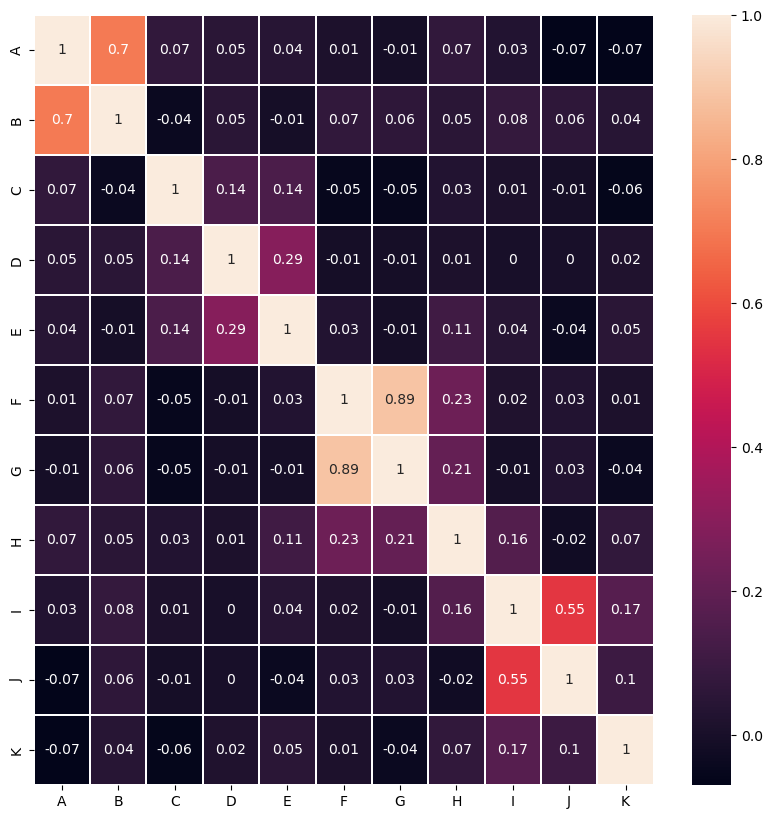

In [15]:
X_spearman_round = X.corr(method='spearman').round(decimals=2)
fig, ax = plt.subplots(figsize=(10,10))         ### Sample figsize in inches
sns.heatmap(X_spearman_round, linewidth=0.3, annot=True)

# Q-Q Plots 

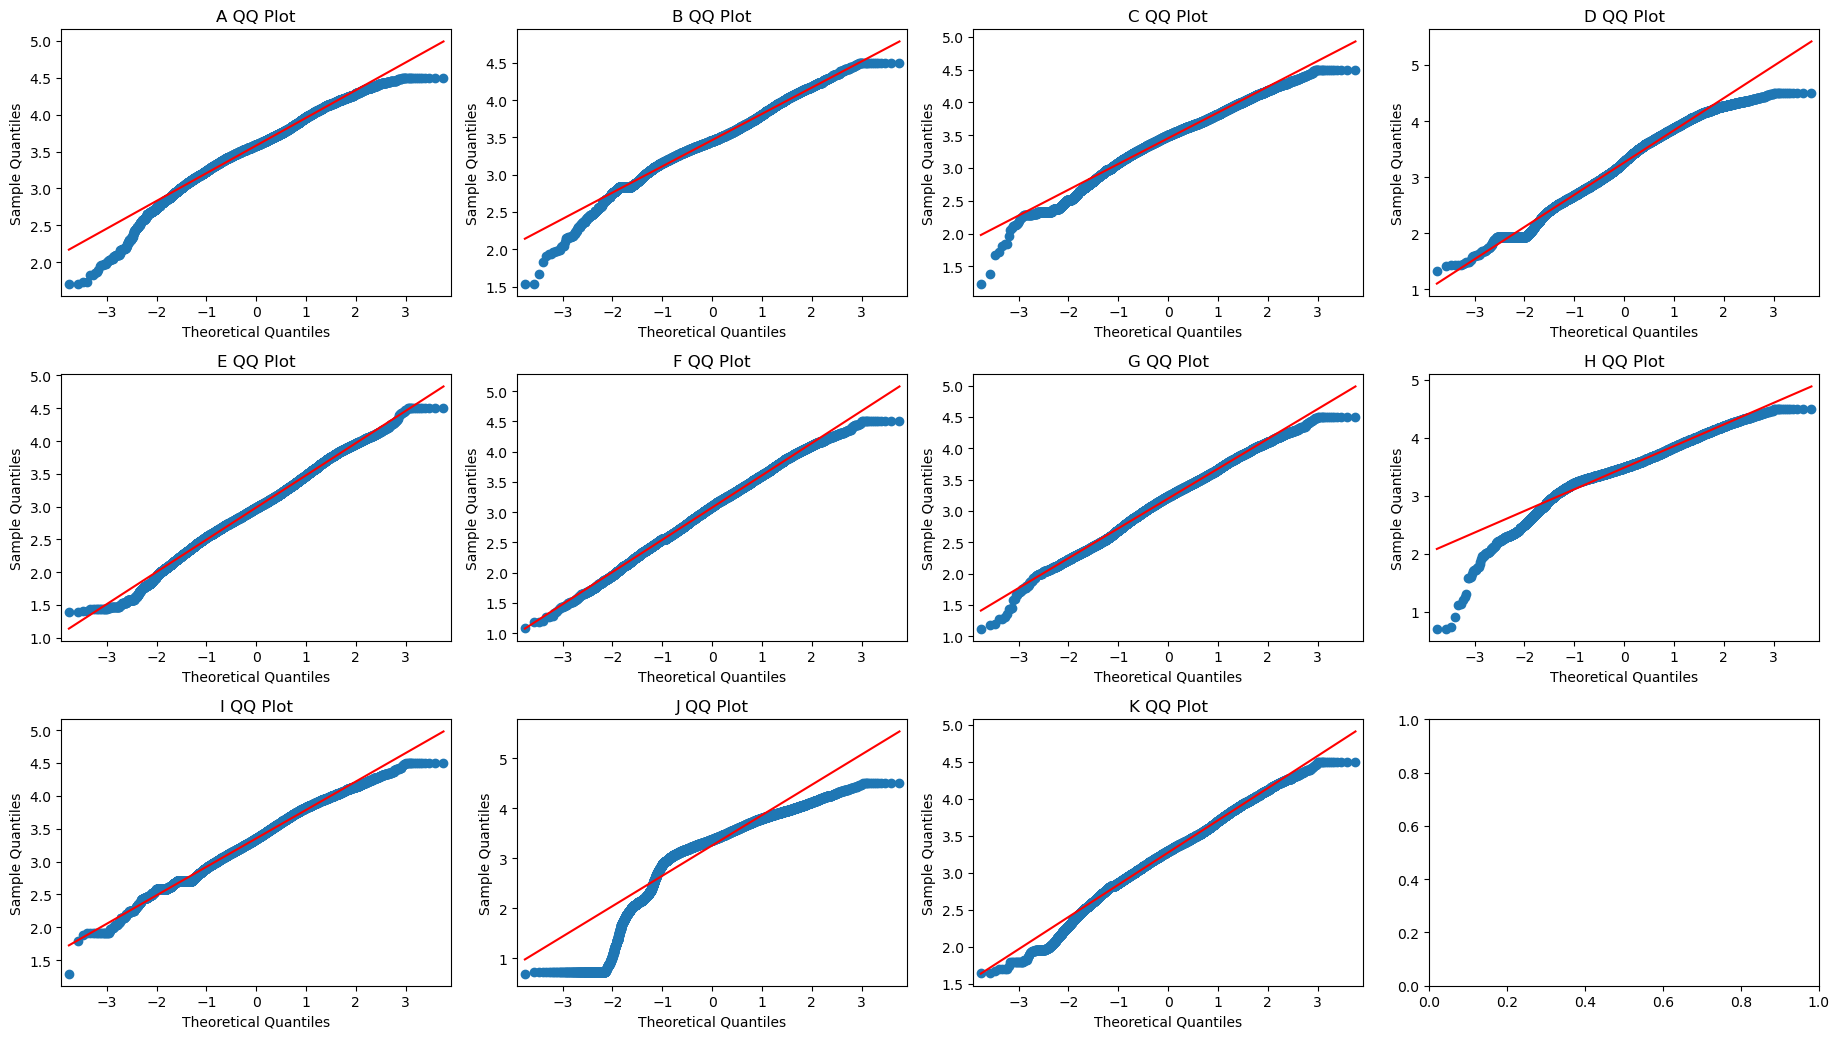

In [16]:
fig, axes = plt.subplots(ncols=4, nrows=3)
fig.set_size_inches(18.5, 10.5)

for k, ax in zip(X.columns, np.ravel(axes)):
    
    sm.qqplot(X[k], line='r', ax=ax)
    ax.set_title(f'{k} QQ Plot')
plt.tight_layout()

# sortnregress algorithm

In [17]:
def sortnregress(X):
    """ Take n x d data, order nodes by marginal variance and
    regresses each node onto those with lower variance, using
    edge coefficients as structure estimates. """
    LR = LinearRegression()
    LL = LassoLarsIC(criterion='bic')

    d = X.shape[1]
    W = np.zeros((d, d))
    increasing = np.argsort(np.var(X, axis=0))
    
    for k in range(1, d):
        covariates = increasing[:k]
        target = increasing[k]

        LR.fit(X.iloc[:, covariates].values, X.iloc[:, target].values.ravel())
        weight = np.abs(LR.coef_)
        LL.fit(X.iloc[:, covariates].values, X.iloc[:, target].values.ravel())
        W[covariates, target] = LL.coef_ * weight
        
    return W

def varsortability(X, W, tol=1e-9):
    """ Takes n x d data and a d x d adjaceny matrix,
    where the i,j-th entry corresponds to the edge weight for i->j,
    and returns a value indicating how well the variance order
    reflects the causal order. """
    E = W != 0
    Ek = E.copy()
    X = X.to_numpy() ### delete if X is numpy array, keep if X is pandas dataframe
    var = np.var(X, axis=0, keepdims=True)

    n_paths = 0
    n_correctly_ordered_paths = 0

    for _ in range(E.shape[0] - 1):
        n_paths += Ek.sum()
        n_correctly_ordered_paths += (Ek * var / var.T > 1 + tol).sum()
        n_correctly_ordered_paths += 1/2*(
            (Ek * var / var.T <= 1 + tol) *
            (Ek * var / var.T >  1 - tol)).sum()
        Ek = Ek.dot(E)

    return n_correctly_ordered_paths / n_paths

In [18]:
W  = sortnregress(X)

#print(W)  ### Uncomment to print adjacency matrix

print(f"\nThe shape is {W.shape}\n")

print(f"The varsortability score for sortnregress is: {varsortability(X, W)}")


The shape is (11, 11)

The varsortability score for sortnregress is: 1.0


## Varsortability 1 means that there is no edge in the final causal DAG going from a node to another that has strictly lower variance.

# Visualization of Causal DAG recovered by the algorithm


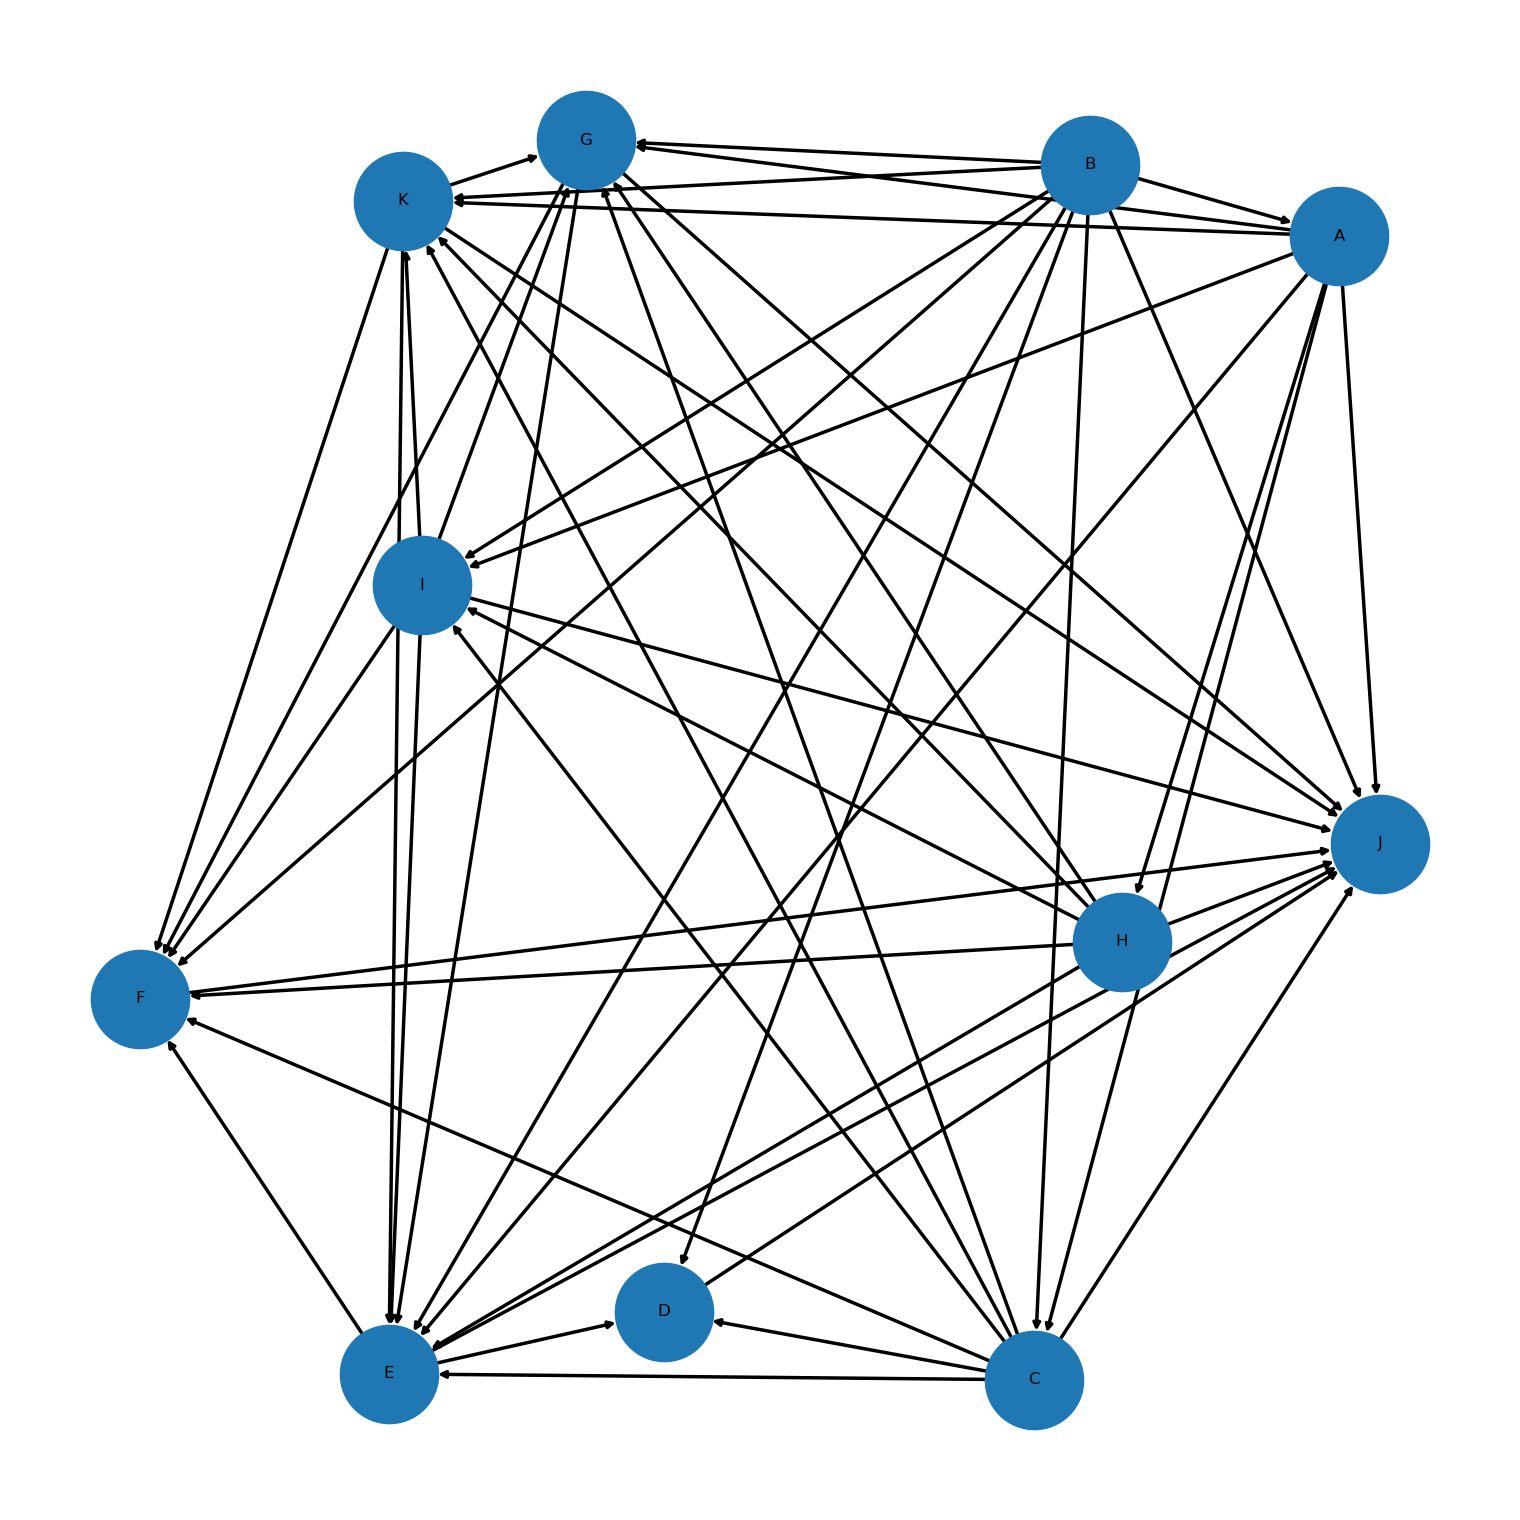

In [19]:
plt.figure(3,figsize=(15,15)) 
label_dict = {
  0: "A",
  1: "B",
  2: "C",
  3: "D",
  4: "E",
  5: "F",
  6: "G",
  7: "H",
  8: "I",    
  9: "J",    
  10: "K"    
}


G =nx.DiGraph(W)
pos = nx.spring_layout(G, k=0.85, iterations=20) ### calculates a specific position for the DAG, instead of a random one every time

nx.draw(G, with_labels=True, node_size=5000, width=2.5, labels=label_dict, pos=pos)

plt.show()

# Other algorithms tested for comparison

# Causal Learn PC Algorithm


In [20]:
data = X.to_numpy()
cg = pc(data)
#cg.draw_pydot_graph()
#cg.to_nx_graph()
#cg.draw()

  0%|          | 0/11 [00:00<?, ?it/s]

In [21]:
cg.G.graph[cg.G.graph<0] = 0 ### make undirected edges directed

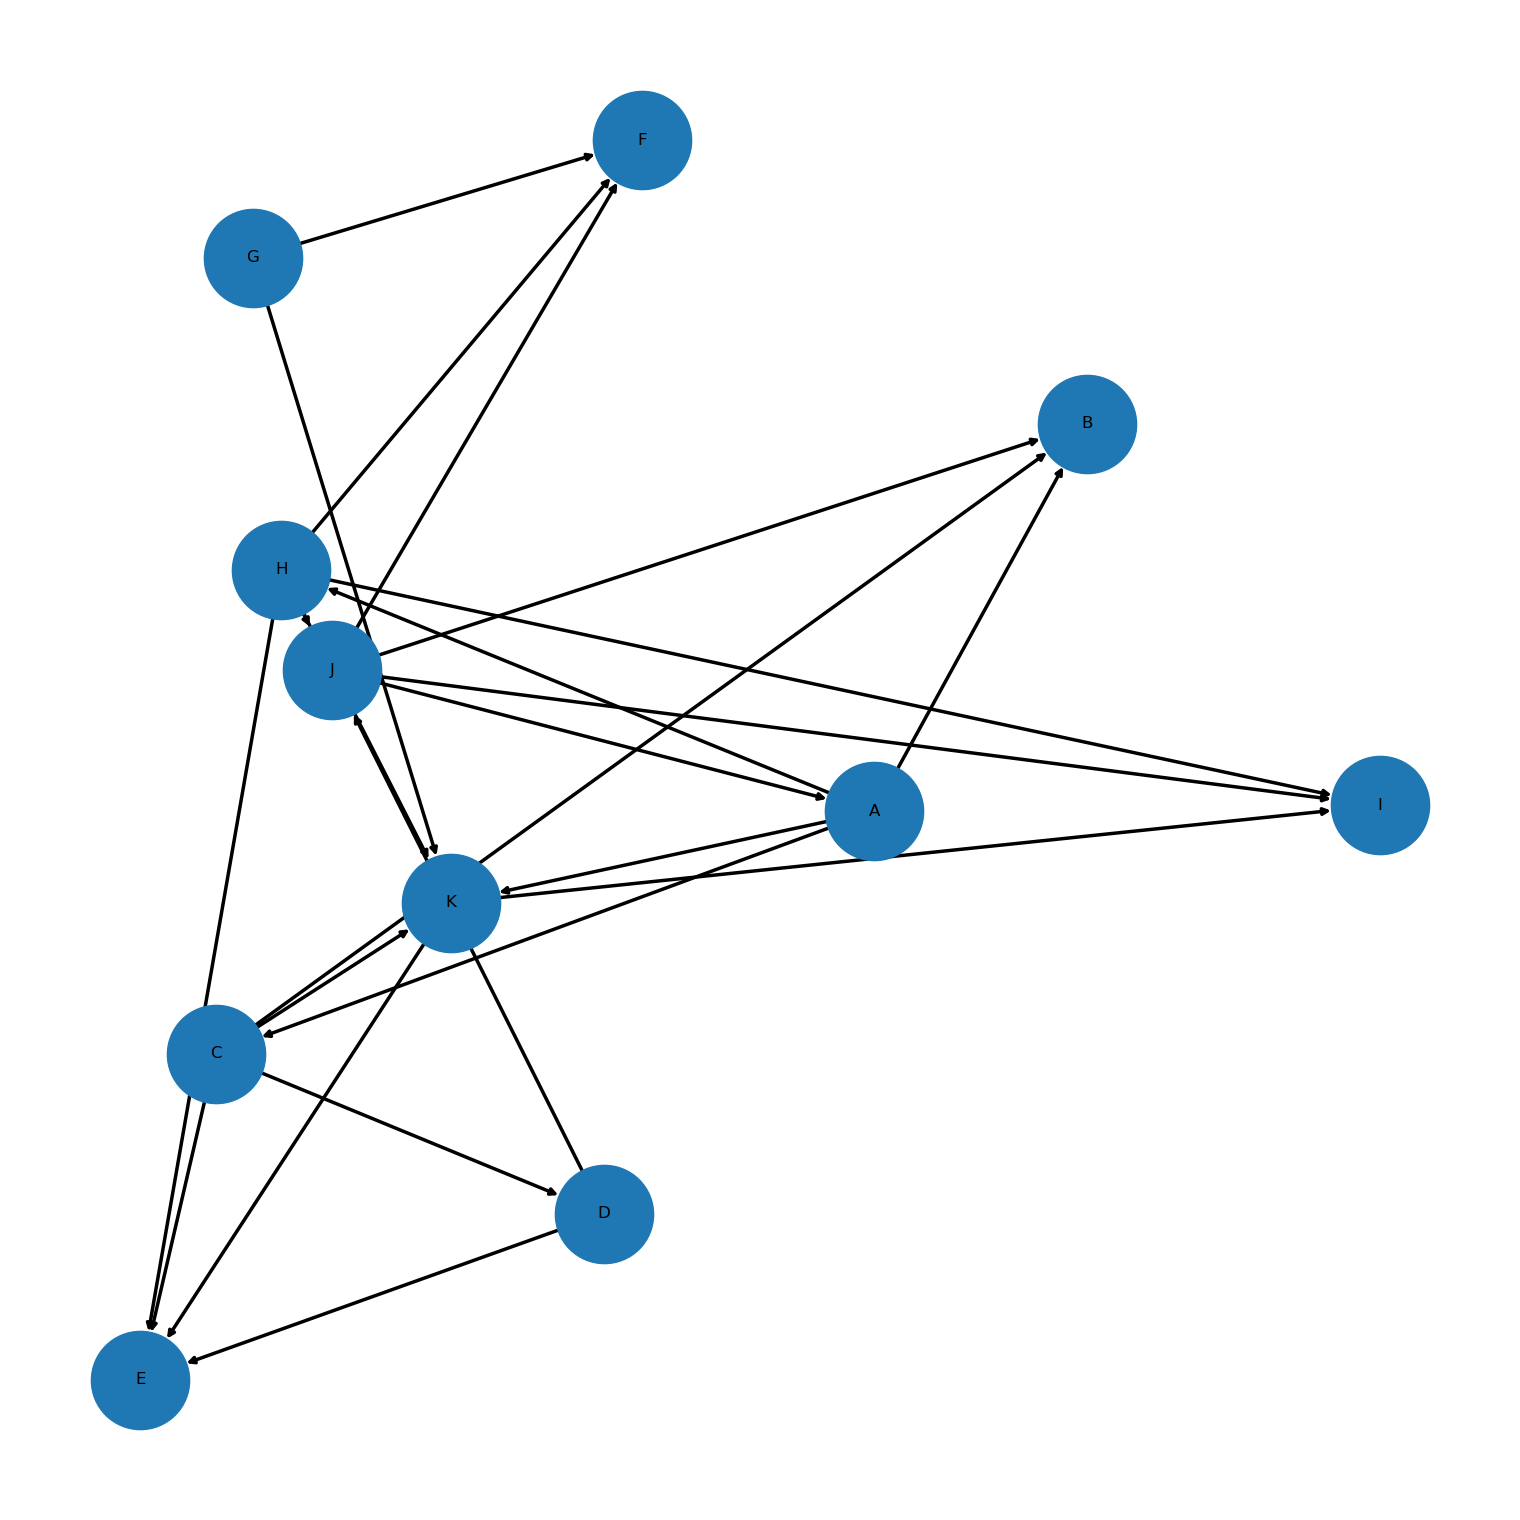

In [22]:
plt.figure(3,figsize=(15,15)) 


G =nx.DiGraph(cg.G.graph)
pos = nx.spring_layout(G, k=0.85, iterations=20)

nx.draw(G, with_labels=True, node_size=5000, width=2.5, labels=label_dict, pos=pos)

plt.show()

In [23]:
varsortability(X, cg.G.graph)

0.49159663865546216

In [24]:
#make_dot(cg.G.graph, labels= ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"])
# make_dot prints edges with wrong direction so it was not used in the final visualizations

# gCastle PC algorithm

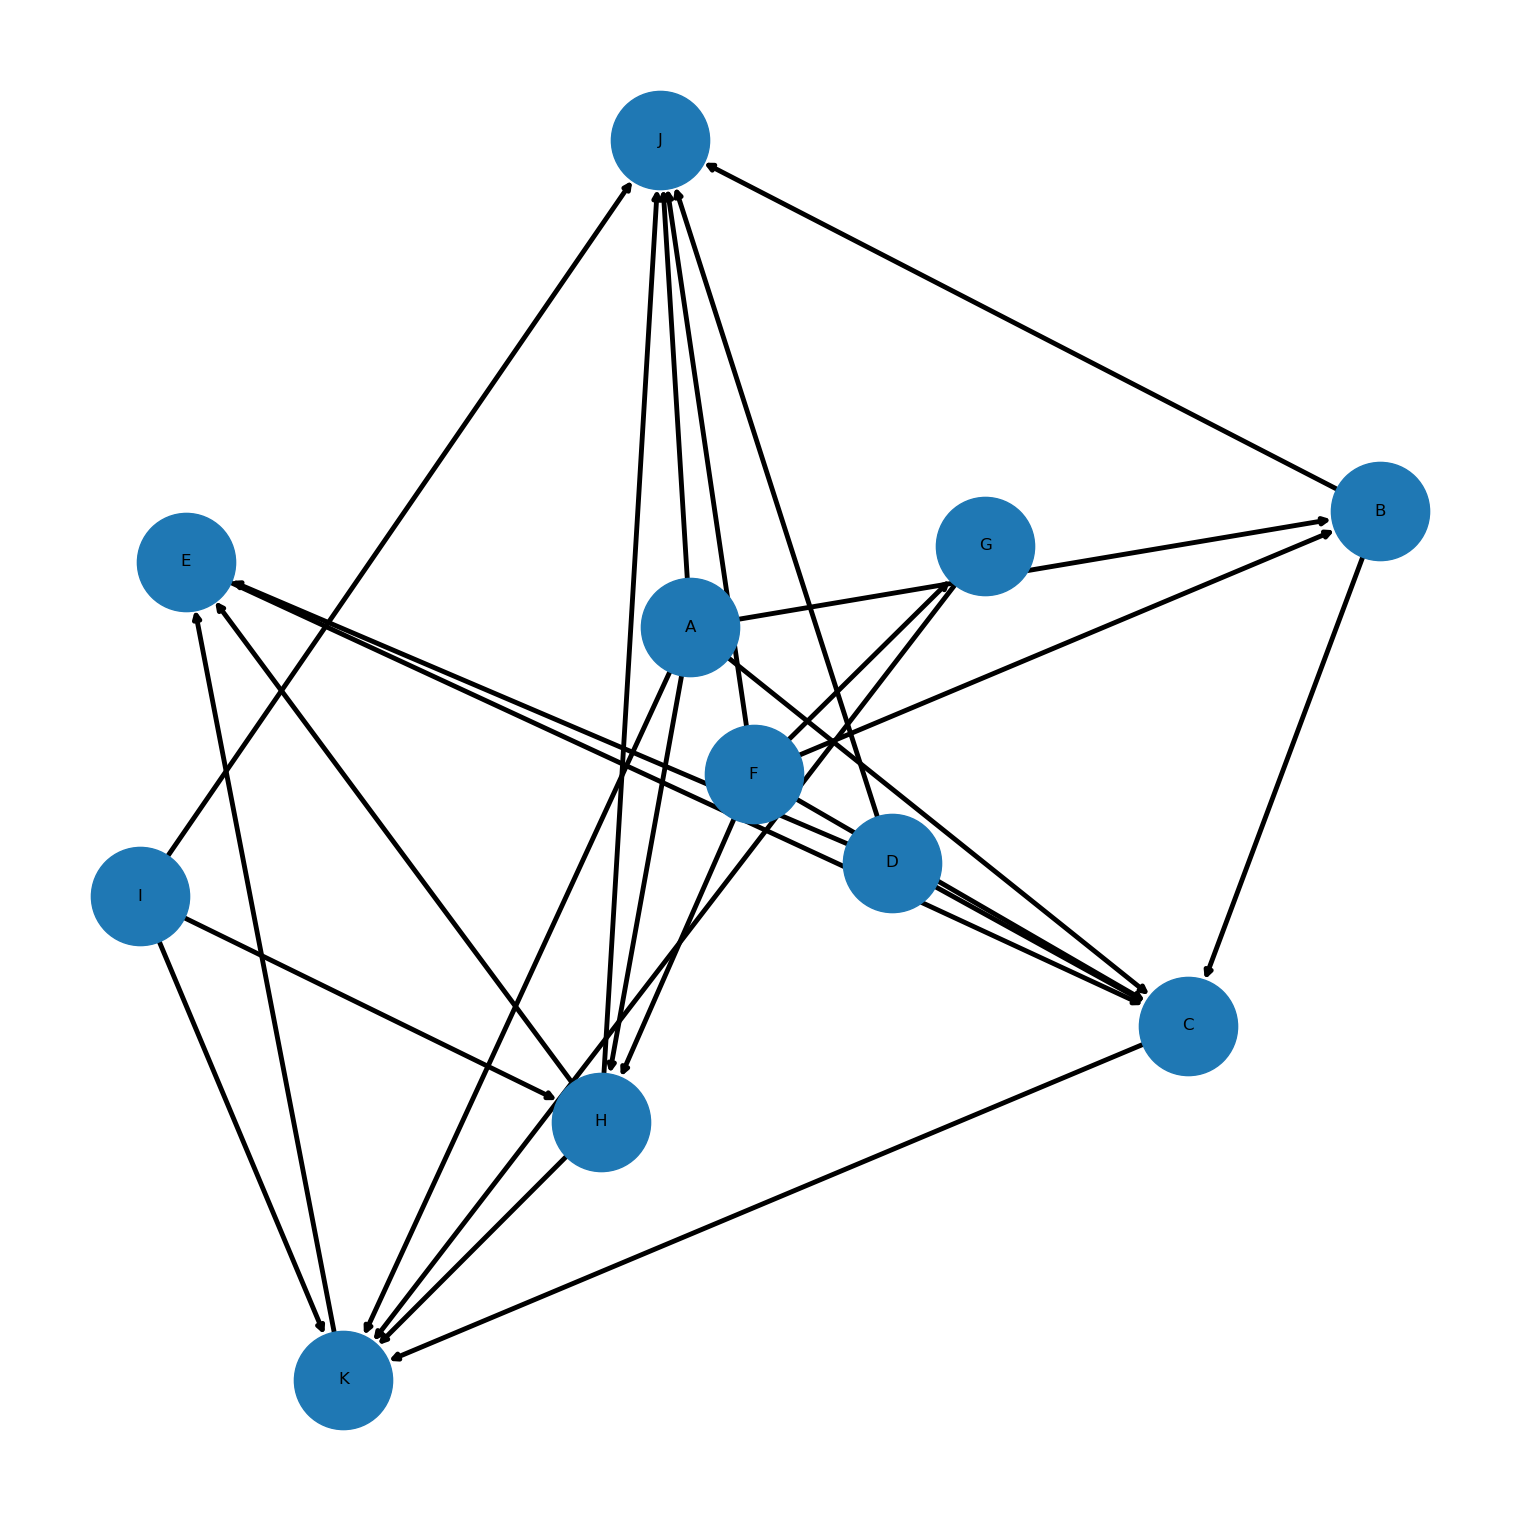

In [25]:
pc = PC()
pc.learn(X)


plt.figure(3,figsize=(15,15)) 


G =nx.DiGraph(pc.causal_matrix)
pos = nx.spring_layout(G, k=0.85, iterations=20)

nx.draw(G, with_labels=True, node_size=5000, width=3.5, labels=label_dict, pos=pos)

plt.show()



In [26]:
W_int = (W>0).astype(int)
Adj_int = (pc.causal_matrix > 0).astype(int)
print(cdt.metrics.SHD(W_int, Adj_int))
#cdt.metrics.precision_recall(W_int, Adj_int) ### causal matrix here is binary, so instead of varsortability, the SHD is presented between sortnregress matrix and this PC matrix(varsortability was producing errors)

38


# DirectLiNGAM from Lingam Library

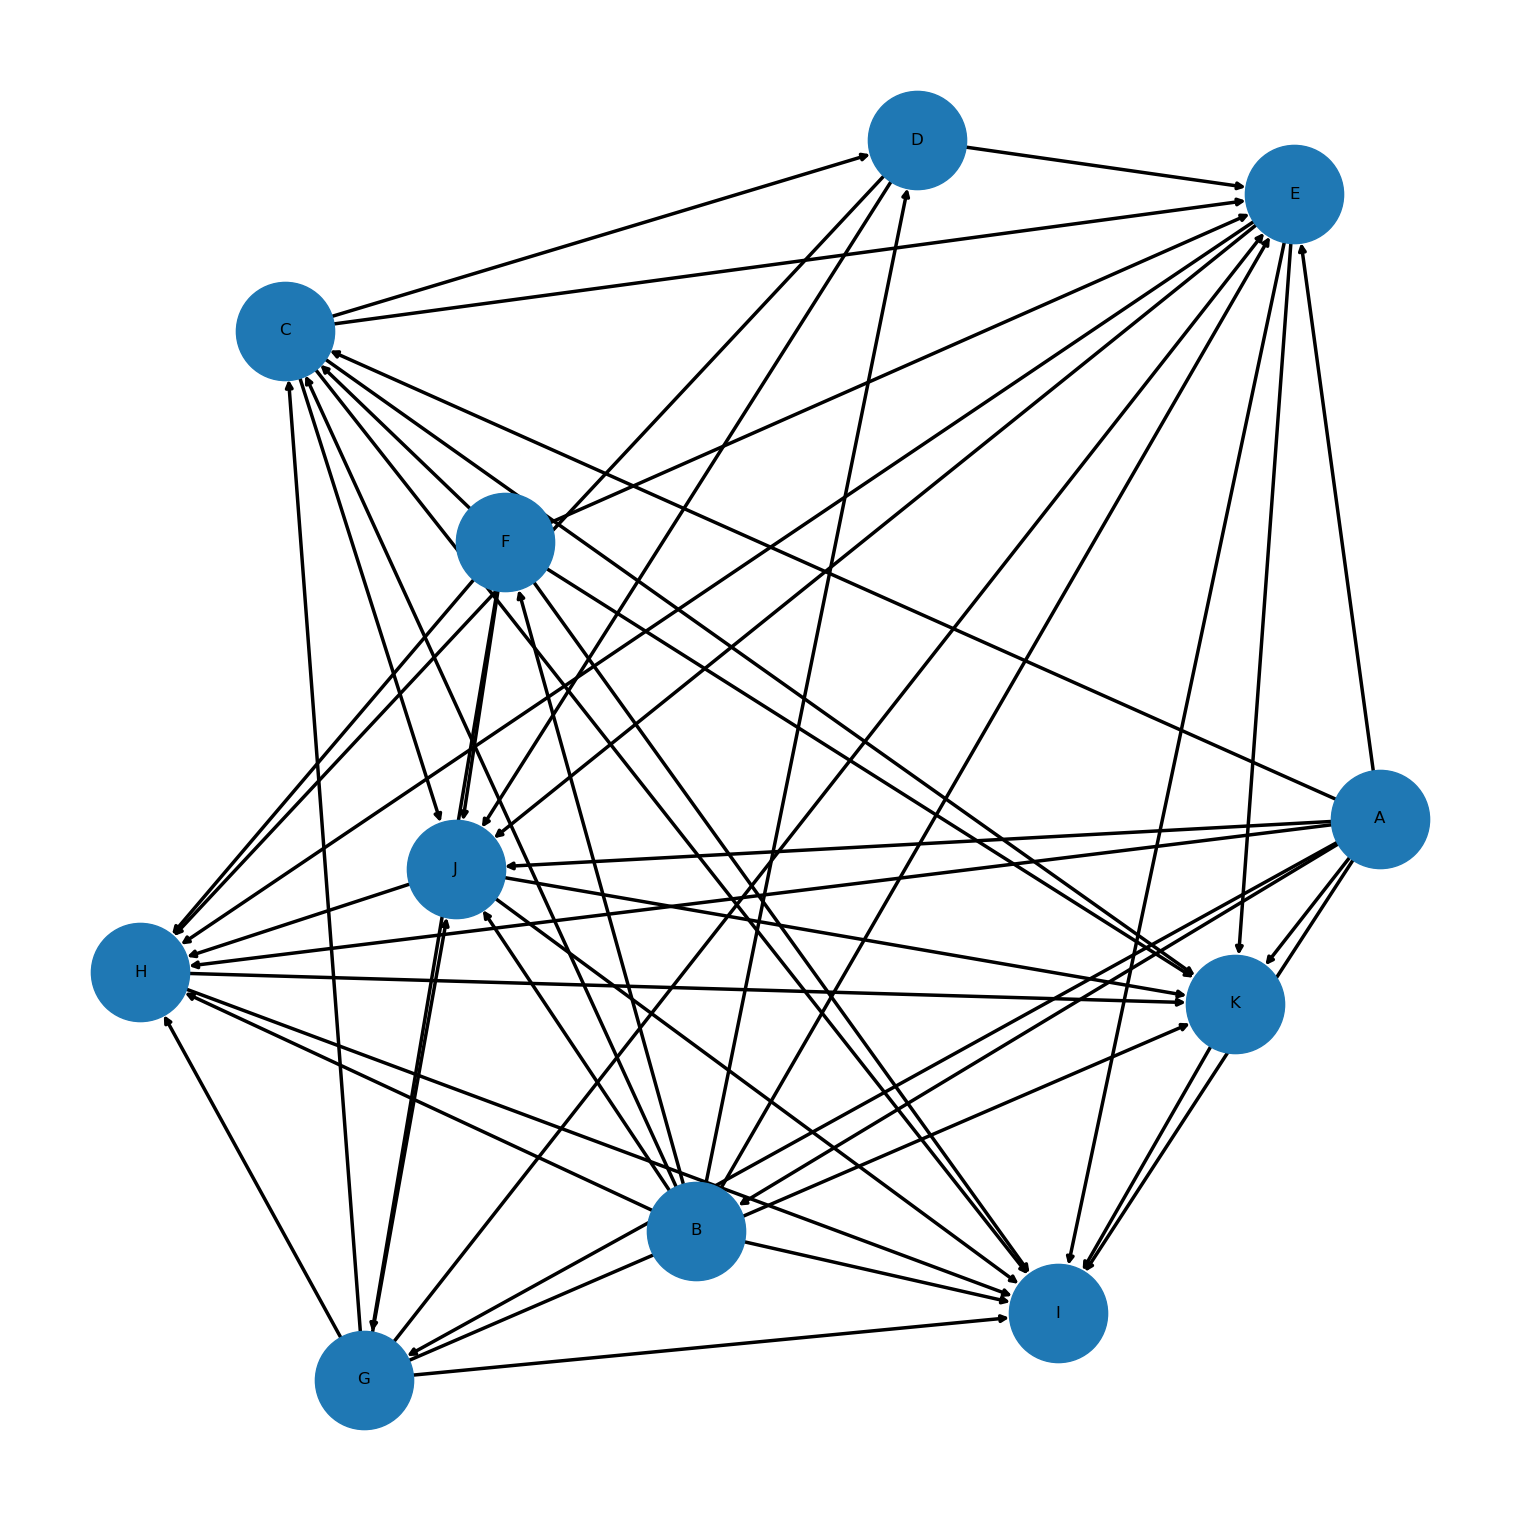

In [27]:
model = lingam.DirectLiNGAM()
model.fit(X)
#make_dot(model.adjacency_matrix_, labels= ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"])

plt.figure(3,figsize=(15,15)) 


G =nx.DiGraph(model.adjacency_matrix_)
pos = nx.spring_layout(G, k=0.85, iterations=20)

nx.draw(G, with_labels=True, node_size=5000, width=2.5, labels=label_dict, pos=pos)

plt.show()

In [28]:
varsortability(X, model.adjacency_matrix_)

0.6285714285714286

# gCastle IcaLiNGAM


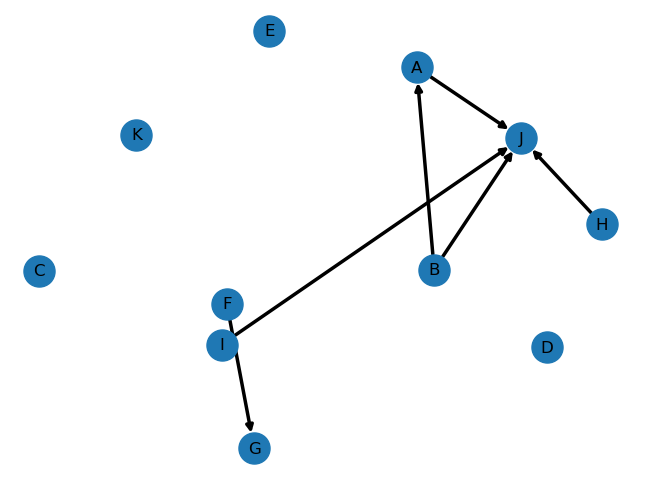

In [29]:
icalingam = ICALiNGAM()
icalingam.learn(X)

G =nx.DiGraph(icalingam.causal_matrix)
pos = nx.spring_layout(G, k=0.85, iterations=20)

nx.draw(G, with_labels=True, node_size=500, width=2.5, labels=label_dict, pos=pos)

plt.show()

# gCastle GES

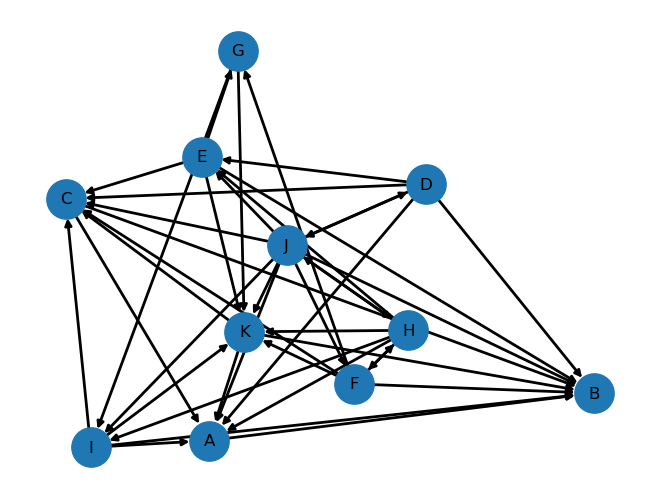

In [30]:
ges = GES()
ges.learn(X)

G =nx.DiGraph(ges.causal_matrix)
pos = nx.spring_layout(G, k=0.85, iterations=20)

nx.draw(G, with_labels=True, node_size=800, width=2, labels=label_dict, pos=pos)

plt.show()

In [31]:
varsortability(X, model.adjacency_matrix_)

0.6285714285714286

# More Statistical Tests perfomed

## Bartlett Test  (Test if samples come from populations with equal variances)

In [32]:
for i in X:
    for j in X:
        #print(f"Bartlett Test for Columns {i} and {j}")
        statistic, pvalue =  bartlett(X[i], X[j])
        #print(bartlett(X[i], X[j]))
        #print("-----------------")
        if statistic < pvalue:
            if i!=j:
                print(f"P value = {pvalue} for columns {i}, {j}")

P value = 0.5547627710285472 for columns I, K
P value = 0.5547627710285472 for columns K, I


In [33]:
for i in X:
    for j in X:
        #print(f"Bartlett Test for Columns {i} and {j}")
        statistic, pvalue =  bartlett(X[i], X[j])
        #print(bartlett(X[i], X[j]))
        #print("-----------------")
        if pvalue>0.05:
            if i!=j:
                print(f"P value = {pvalue} for columns {i}, {j}")

P value = 0.3919312323387152 for columns A, H
P value = 0.3919312323387152 for columns H, A
P value = 0.5547627710285472 for columns I, K
P value = 0.5547627710285472 for columns K, I


# Levene Test (Test if samples come from populations with equal variances, less sensitive to departures from normality than Bartlett)

In [34]:
for i in X:
    for j in X:
        #print(f"Bartlett Test for Columns {i} and {j}")
        statistic, pvalue =  levene(X[i], X[j])
        #print(bartlett(X[i], X[j]))
        #print("-----------------")
        if statistic < pvalue:
            if i!=j:
                print(f"P value = {pvalue} for columns {i}, {j}")

In [35]:
for i in X.columns:
    for j in X.columns:
        #print(f"For columns: {i} and {j}")
        statistic, pvalue = levene(X[i], X[j])
        #print("--------")
        if pvalue > 0.05:
            if i!=j:
                print(f"For columns: {i} and {j}")
                print(pvalue)
                print("-------")

For columns: E and G
0.23189121685337782
-------
For columns: G and E
0.23189121685337782
-------


# Shapiro-Wilk Test, and Anderson-Darling Test (Test if sample comes from population that has a normal distribution) 

In [36]:
for column in X.columns:
    print(column)
    print(shapiro(X[column]))
    print("")
    print(anderson(X[column], dist='norm'))
    print('--------------')

A
ShapiroResult(statistic=0.9825955629348755, pvalue=2.4063157137697706e-35)

AndersonResult(statistic=32.77731877956103, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
--------------
B
ShapiroResult(statistic=0.9883275628089905, pvalue=8.510142004133952e-30)

AndersonResult(statistic=38.57728953824517, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
--------------
C
ShapiroResult(statistic=0.9835174083709717, pvalue=1.4669651775652557e-34)

AndersonResult(statistic=52.60476664932867, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
--------------
D
ShapiroResult(statistic=0.9865343570709229, pvalue=1.0049927743668724e-31)

AndersonResult(statistic=35.75437520303967, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. 

## Percentage of data between mean-std, mean+std, and mean-2std, mean+2std

In [37]:
for i in X.columns:
    print(f"For column {i}:")
    print(np.mean((X[i]>X[i].mean()-1*X[i].std()) & (X[i]<X[i].mean()+1*X[i].std())) * 100) ### percentage of data between mean-1std, mean+1std
    print(np.mean((X[i]>X[i].mean()-2*X[i].std()) & (X[i]<X[i].mean()+2*X[i].std())) * 100) ### percentage of data between mean-2std, mean+2std
    print('---------------------------')

For column A:
69.50822481151474
95.29643591501028
---------------------------
For column B:
71.9842357779301
95.31357093899932
---------------------------
For column C:
71.07607950651132
94.56819739547635
---------------------------
For column D:
66.14119259766964
96.11891706648389
---------------------------
For column E:
69.83379026730637
95.18505825908157
---------------------------
For column F:
68.64290610006853
95.53632625085675
---------------------------
For column G:
67.7004797806717
95.79335161069226
---------------------------
For column H:
74.80294722412611
94.2340644276902
---------------------------
For column I:
65.11309115832762
97.06134338588073
---------------------------
For column J:
78.86394790952707
95.15935572309802
---------------------------
For column K:
70.19362577107609
94.6881425633996
---------------------------


# F test for 2 nodes


In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
X_numpy = X.to_numpy()

## D->G

In [40]:
features1 = X_numpy[:,3]
print(features1.shape)
features2 = X_numpy[:,6]
print(features2.shape)

features1 = features1.reshape(-1,1)
features2 = features2.reshape(-1,1)

print(features1.shape)
print(features2.shape)

(11672,)
(11672,)
(11672, 1)
(11672, 1)


In [41]:
reg = LinearRegression().fit(features1, features2)

In [42]:
reg.coef_

array([[-0.011]])

In [43]:
modelsm = sm.OLS(features2, features1)

result = modelsm.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                          2.117e+05
Date:                Wed, 08 Mar 2023   Prob (F-statistic):                        0.00
Time:                        18:04:02   Log-Likelihood:                         -13033.
No. Observations:               11672   AIC:                                  2.607e+04
Df Residuals:                   11671   BIC:                                  2.608e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9506      0.002    460.072      0.000       0.947       0.955
==============================================================================
Omnibus:                      129.452   Durbin-Watson:                   1.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.115
Skew:                           0.073   Prob(JB):                     2.00e-19
Kurtosis:                       2.606   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
result.bse

array([0.002])

In [45]:
result.params

array([0.951])

In [46]:
t = result.params / result.bse

pvalue = 2 * norm.cdf(np.abs(t))

print(pvalue)

[2.]


## G -> D

In [47]:
modelsm = sm.OLS(features1, features2)

result = modelsm.fit()

result.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                          2.117e+05
Date:                Wed, 08 Mar 2023   Prob (F-statistic):                        0.00
Time:                        18:04:02   Log-Likelihood:                         -13312.
No. Observations:               11672   AIC:                                  2.663e+04
Df Residuals:                   11671   BIC:                                  2.663e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9970      0.002    460.072      0.000       0.993       1.001
==============================================================================
Omnibus:                      138.131   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.729
Skew:                          -0.088   Prob(JB):                     7.31e-21
Kurtosis:                       2.600   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""